In [26]:
import os
import datetime
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from modules.Utils.utils import loadFromDB, strategyTester, getFearAndGreedIndicator,computeStochasticLinearRegression
from modules.Utils.indicators import computeSuperTrend, addIndicators, computeLaggingLinearRegression, computeTrixIndicator, generateDatesFeatures


from random import randint
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource,Span
from bokeh.layouts import row, column
output_notebook()

import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from PyEMD import EMD,CEEMDAN, EEMD
from sklearn.feature_selection import mutual_info_regression

Loading BokehJS ...

In [27]:
def computeEMD(df):
    def emd(signal):
        return EMD(DTYPE=np.float16, spline_kind='cubic')(signal.values)
    def phase_spectrum(imfs):
        imfs_p = []
        for i, imf in enumerate(imfs):
            trans = fft(imf)
            imfs_p.append(np.arctan(trans.imag / trans.real))           
        return imfs_p
    def phase_mi(phases):
        return np.array([mutual_info_regression(phases[i].reshape(-1, 1), phases[i+1])[0] for i in range(len(phases)-1)])
    def divide_signal(signal, imfs, mis, cutoff=0.75):
        cut_point = np.where(mis > cutoff)[0][0]
        return np.sum(imfs[:cut_point], axis=0), np.sum(imfs[cut_point:], axis=0)
    imfs = emd(df["Close"])

    stochastic_component, deterministic_component = divide_signal(df["Close"], imfs, phase_mi(phase_spectrum(imfs)),cutoff=0.96)
    df['EMD_S']=stochastic_component
    df['EMD_D']=deterministic_component
    return df

In [28]:
SYMBOL= 'BTC'
df = loadFromDB(f'./data/1h/{SYMBOL}-USDT.csv')
df = addIndicators(df,derivative=True, b_engulfings=True)
df = computeLaggingLinearRegression(df, 'Close',20, False,derivative=False)
df = computeStochasticLinearRegression(df,"Close")
df = computeTrixIndicator(df, col='Close')
df = generateDatesFeatures(df)
df = computeEMD(df)
df = getFearAndGreedIndicator(df)
df.dropna(inplace=True)
print(df.shape)
print(df.columns)
df.head()

(23184, 38)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'Bullish_engulfing', 'Bearish_engulfing', 'Slope',
       'B_MLR_coefs', 'Stochastic_prediction', 'Trix', 'Trix_histo', 'Month',
       'Year', 'Week', 'Hour', 'Year_sin', 'Year_cos', 'EMD_S', 'EMD_D',
       'FnG'],
      dtype='object')


,Open,High,Low,Close,Volume,Timestamp,High_Low_diff,EMA20,EMA50,EMA100,...,Trix_histo,Month,Year,Week,Hour,Year_sin,Year_cos,EMD_S,EMD_D,FnG
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-12 04:00:00,8095.00,8110.92,8065.62,8091.33,963.637569,1578798000,45.30,8089.782443,8048.379011,7976.638385,...,-0.052148,1,2020,2,4,0.188807,0.982014,-43.614483,8134.944483,45
2020-01-12 05:00:00,8090.70,8105.00,8071.20,8073.79,711.211749,1578801600,33.80,8088.259353,8049.375521,7978.562179,...,-0.048403,1,2020,2,5,0.189511,0.981879,-57.932028,8131.722028,45
2020-01-12 06:00:00,8073.03,8110.92,8070.98,8106.05,997.127263,1578805200,39.94,8089.953701,8051.598049,7981.086690,...,-0.041874,1,2020,2,6,0.190215,0.981743,-22.176112,8128.226112,45
2020-01-12 07:00:00,8105.96,8153.84,8080.01,8083.84,2509.947391,1578808800,73.83,8089.371444,8052.862440,7983.121409,...,-0.036312,1,2020,2,7,0.190918,0.981606,-40.603638,8124.443638,45
2020-01-12 08:00:00,8083.43,8110.00,8080.45,8097.51,867.095068,1578812400,29.55,8090.146544,8054.613324,7985.386530,...,-0.030390,1,2020,2,8,0.191622,0.981469,-22.858759,8120.368759,45


In [29]:
n = len(df)
train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
 
def split_sequence(sequence,
                    look_back,
                    forecast_horizon,
                    coverage,
                    column_labels=['EMA20']):
    X, y = [], []
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        X.append(sequence.iloc[i:lag_end])
        y.append(sequence.iloc[lag_end-coverage:forecast_end][column_labels])
    return np.array(X), np.array(y)

In [30]:
INPUT_STEPS = 60
OUTPUT_STEPS = 20
COVERAGE_STEPS = 20
OUTPUT_SIZE = COVERAGE_STEPS+OUTPUT_STEPS

X,y = split_sequence(train_df,INPUT_STEPS,OUTPUT_STEPS,COVERAGE_STEPS,column_labels=['B_MLR_coefs'])

# LSTM

In [134]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=False,dropout=0.2),
    tf.keras.layers.Dense(OUTPUT_SIZE*1,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
])

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = lstm_model.fit(X,y,
                    epochs=30,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=8,
                                                       mode='min')],
                    use_multiprocessing=True)


Epoch 1/30
231/231 [==============================] - 10s 34ms/step - loss: 0.4868 - mean_absolute_error: 0.3955 - val_loss: 0.5142 - val_mean_absolute_error: 0.5119
Epoch 2/30
231/231 [==============================] - 6s 28ms/step - loss: 0.2589 - mean_absolute_error: 0.2971 - val_loss: 0.4145 - val_mean_absolute_error: 0.4593
Epoch 3/30
231/231 [==============================] - 7s 29ms/step - loss: 0.2089 - mean_absolute_error: 0.2640 - val_loss: 0.3715 - val_mean_absolute_error: 0.4319
Epoch 4/30
231/231 [==============================] - 7s 29ms/step - loss: 0.1854 - mean_absolute_error: 0.2473 - val_loss: 0.3946 - val_mean_absolute_error: 0.4541
Epoch 5/30
231/231 [==============================] - 7s 30ms/step - loss: 0.1713 - mean_absolute_error: 0.2389 - val_loss: 0.3700 - val_mean_absolute_error: 0.4347
Epoch 6/30
231/231 [==============================] - 7s 29ms/step - loss: 0.1638 - mean_absolute_error: 0.2348 - val_loss: 0.3828 - val_mean_absolute_error: 0.4417
Epoch 7/3

# CONV

In [135]:
CONV_WIDTH=3
conv_model = tf.keras.Sequential([
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid', data_format='channels_last'),
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUTPUT_SIZE*1,kernel_initializer=tf.initializers.zeros(),),
    tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
])


conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

            
history = conv_model.fit(X,y,
                    epochs=30,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=8,
                                                    mode='min')],
                    use_multiprocessing=True)


Epoch 1/30
462/462 [==============================] - 1s 2ms/step - loss: 0.2725 - mean_absolute_error: 0.2915 - val_loss: 0.3736 - val_mean_absolute_error: 0.4330
Epoch 2/30
462/462 [==============================] - 1s 2ms/step - loss: 0.1893 - mean_absolute_error: 0.2455 - val_loss: 0.3758 - val_mean_absolute_error: 0.4266
Epoch 3/30
462/462 [==============================] - 1s 2ms/step - loss: 0.1747 - mean_absolute_error: 0.2364 - val_loss: 0.3409 - val_mean_absolute_error: 0.4013
Epoch 4/30
462/462 [==============================] - 1s 2ms/step - loss: 0.1673 - mean_absolute_error: 0.2326 - val_loss: 0.3782 - val_mean_absolute_error: 0.4387
Epoch 5/30
462/462 [==============================] - 1s 2ms/step - loss: 0.1567 - mean_absolute_error: 0.2239 - val_loss: 0.3594 - val_mean_absolute_error: 0.4067
Epoch 6/30
462/462 [==============================] - 1s 2ms/step - loss: 0.1517 - mean_absolute_error: 0.2212 - val_loss: 0.3692 - val_mean_absolute_error: 0.4173
Epoch 7/30
462/4

# Test

In [136]:
pred_lstm = lstm_model.predict(X)
pred_conv = conv_model.predict(X)

578/578 [==============================] - 1s 968us/step


In [137]:
lstm_model.save(f'./models/{SYMBOL}_lstm_model.h5')
conv_model.save(f'./models/{SYMBOL}_conv_model.h5')

In [144]:
ind = randint(0,len(X)-1)
print(ind)


p = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
#p.line(list(range(len(y[ind]))), pred_conv[ind].reshape(OUTPUT_SIZE), legend_label="Conv Prediction", line_width=2, line_alpha=.7,color='red')
#p.line(list(range(len(y[ind]))), pred_lstm[ind].reshape(OUTPUT_SIZE), legend_label="LSTM Prediction", line_width=2, line_alpha=.7,color='yellow')
p.line(list(range(len(y[ind]))), (pred_conv[ind].reshape(OUTPUT_SIZE)+ pred_lstm[ind].reshape(OUTPUT_SIZE))/2, legend_label="LSTM x Conv Prediction", line_width=2, color='orange')
p.line(list(range(len(y[ind]))), y[ind].reshape(OUTPUT_SIZE), legend_label="B_MLR_coefs", line_width=2, )
vline = Span(location=COVERAGE_STEPS, dimension='height', line_color='black', line_width=2,line_dash='dashed')
p.renderers.extend([vline])
p.legend.location = "top_left"

show(p)

14470


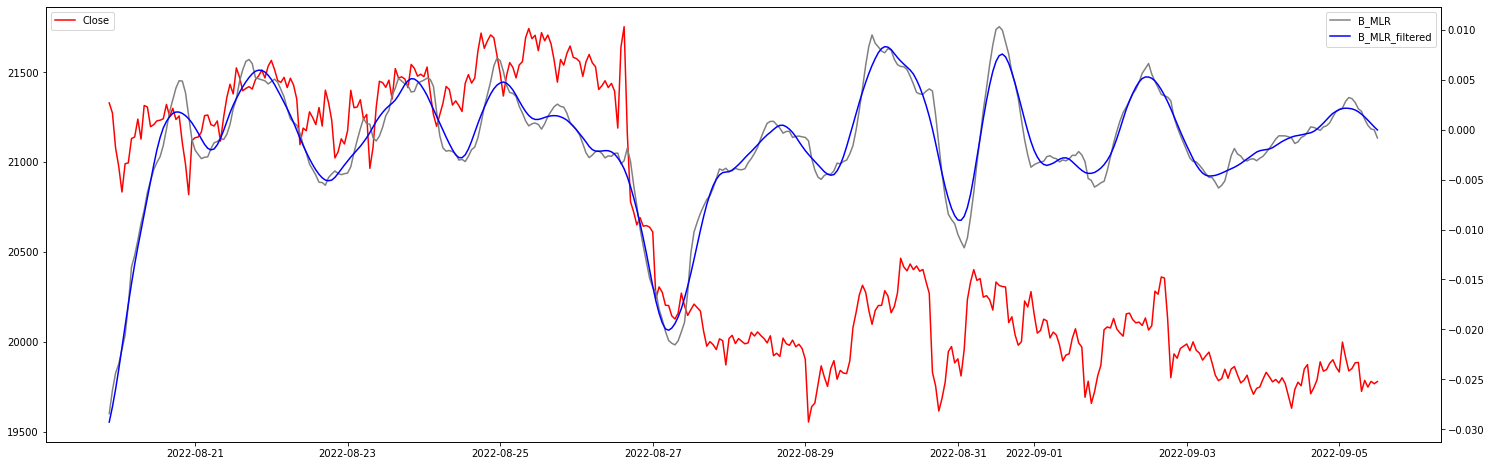

In [132]:
from scipy.signal import savgol_filter

df['B_MLR_coefs_denoised'] = savgol_filter(df.B_MLR_coefs.values, 25, 2, mode='nearest')
fig, ax_left = plt.subplots(1, figsize=(25,8))
ax_right =[]

ax_right = ax_left.twinx()

ax_left.plot(df.Close[-400:], color='red',label='Close')
ax_right.plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right.plot(df.B_MLR_coefs_denoised[-400:], color='blue',label='B_MLR_filtered')
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")


In [139]:
df['B_MLR_coefs_denoised_diff'] = df.B_MLR_coefs_denoised.diff(1)
df.dropna(inplace=True)

Period : [2020-01-12 05:00:00] -> [2022-09-05 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 47829246.83 $
Performance vs US Dollar : 4782824.68 %
Buy and Hold Performence : 145.0 %
Performance vs Buy and Hold : 3298415.42 %
Best trade : +19.8 %, the 2020-04-30 05:00:00
Worst trade : -6.37 %, the 2022-01-22 00:00:00
Worst drawBack : -11.0 %
Total fees :  7224931.91 $

----- Trades Informations -----
Total trades on period : 737
Number of positive trades : 497
Number of negative trades :  240
Trades win rate ratio : 67.44 %
Average trades performance : 1.59 %
Average positive trades : 2.82 %
Average negative trades : -0.95 %

----- Plot -----


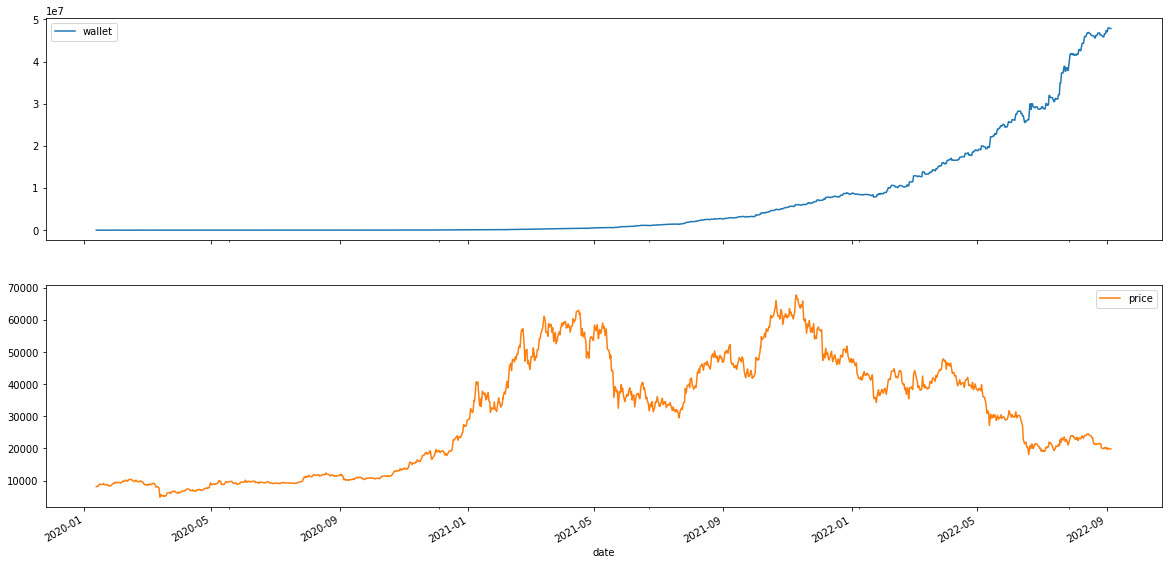

In [140]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.B_MLR_coefs_denoised_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.B_MLR_coefs_denoised_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# Tuning

In [ ]:
#import keras_tuner
#
#def build_model(hp):
#    CONV_WIDTH = hp.Int("CONV_WIDTH", min_value=2, max_value=6, step=2)
#    model = tf.keras.Sequential([
#        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
#        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
#        # Shape => [batch, 1, conv_units]
#        tf.keras.layers.Conv1D(256, activation=hp.Choice("activation", ["relu", "tanh"]), kernel_size=(CONV_WIDTH)),
#        # Shape => [batch, 1,  out_steps*features]
#        tf.keras.layers.Dense(OUTPUT_SIZE*1,
#                            kernel_initializer=tf.initializers.zeros()),
#        # Shape => [batch, out_steps, features]
#        tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
#    ])
#
#    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                        patience=8,
#                                                        mode='min')
#
#    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
#    model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
#                metrics=[tf.keras.metrics.MeanAbsoluteError()])
#    return model
#
#
##build_model(keras_tuner.HyperParameters())
#
#tuner = keras_tuner.RandomSearch(
#    hypermodel=build_model,
#    objective="val_mean_absolute_error",
#    max_trials=10,
#    executions_per_trial=1,
#    overwrite=True,
#    #directory="my_dir",
#    #project_name="helloworld",
#)
#tuner.search_space_summary()
#
#
#tuner.search(X,
#            y,
#            epochs=30,
#            validation_split=0.2,
#            #callbacks=[early_stopping],
#            use_multiprocessing=True)
#            
#models = tuner.get_best_models(num_models=2)
#model = models[0]

In [13]:
CONV_WIDTH=3
conv_model=tf.keras.models.load_model(f'./models/{SYMBOL}_conv_model.h5')


In [17]:
print(conv_model.input.shape.as_list()[-1])

38


In [19]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(conv_model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp63el9lyf\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmp63el9lyf\assets


In [113]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.float32(X)#np.array(np.float32(X[-1].reshape(1,60,38)), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'],np.float32(X[-1].reshape(1,60,38)))
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[[-0.20947276]
  [-0.2843081 ]
  [-0.3232498 ]
  [-0.32669893]
  [-0.28033227]
  [-0.2721059 ]
  [-0.24495617]
  [-0.21126309]
  [-0.21891075]
  [-0.20581608]
  [-0.18926923]
  [-0.1680349 ]
  [-0.17277008]
  [-0.14721811]
  [-0.19549854]
  [-0.16788149]
  [-0.13977744]
  [ 0.02670632]
  [ 0.08583194]
  [ 0.2677865 ]
  [ 0.4169286 ]
  [ 0.5213045 ]
  [ 0.51988983]
  [ 0.54967576]
  [ 0.5340967 ]
  [ 0.45028526]
  [ 0.39788154]
  [ 0.4283916 ]
  [ 0.457385  ]
  [ 0.5075993 ]
  [ 0.54057854]
  [ 0.5067245 ]
  [ 0.42381254]
  [ 0.31651902]
  [ 0.11549266]
  [-0.08445835]
  [-0.27094653]
  [-0.43976447]
  [-0.5522307 ]
  [-0.53972036]]]
